## References

### Flux
[Flux model-zoo: conv.jl]("https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl") <br>
[Flux model-zoo: lenet_mnist.jl]("https://github.com/FluxML/model-zoo/blob/master/vision/lenet_mnist/lenet_mnist.jl") <br>
[Flux model-zoo: dcgan_mnist.jl]("https://github.com/FluxML/model-zoo/blob/master/vision/dcgan_mnist/dcgan_mnist.jl") <br>
[Julia Flux Convolutional Neural Network Explained]("https://spcman.github.io/getting-to-know-julia/deep-learning/vision/flux-cnn-zoo/") <br>
[Flux: regularisation]("https://fluxml.ai/Flux.jl/stable/models/regularisation/") <br>
[Flux: saving]("https://fluxml.ai/Flux.jl/stable/saving/") <br>
[Github: Model optimization fails (NaNs) with Zygote.pullback but works with Tracker.forward]("https://github.com/FluxML/Flux.jl/issues/876") <br>
[Discourse: How come Flux.jl’s network parameters go to NaN?]("https://discourse.julialang.org/t/how-come-flux-jls-network-parameters-go-to-nan/16439/4") <br>
[Discourse: How to do L2 regularization with new Flux and Zygote]("https://discourse.julialang.org/t/how-to-do-l2-regularization-with-new-flux-and-zygote/31756/2") <br>
[Reddit: L1 Regularization Flux+CuArrays]("https://www.reddit.com/r/Julia/comments/g5uxab/l1_regularization_fluxcuarrays/") <br> 

### tensorflow
[Doc: KLDivergence]("https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence") <br>

### keras
[Github: kullback_leibler_divergence]("https://github.com/keras-team/keras/blob/master/keras/losses.py#L711-L714") <br>

### Image
[SO: Reading image info in Julia without loading the images]("https://stackoverflow.com/questions/43188201/reading-image-info-in-julia-without-loading-the-images") <br>
[SO: image to array]("https://stackoverflow.com/questions/59344708/strange-and-uninformative-error-in-my-simple-julia-flux-dense-model") <br>
[Githun: image to array(cifar10.jl)]("https://github.com/FluxML/model-zoo/blob/master/vision/cifar10/cifar10.jl") <br>

### IO
[Github: read file]("https://github.com/FluxML/Metalhead.jl/blob/sf/training/training/ImageNet/dataset.jl") <br>

## Import Packages

In [1]:
using Pkg
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Pkg/src/Pkg.jl:554


Dict{String,VersionNumber} with 14 entries:
  "DrWatson"          => v"1.16.1"
  "BSON"              => v"0.2.6"
  "MLDatasets"        => v"0.5.2"
  "ScikitLearn"       => v"0.6.2"
  "Images"            => v"0.23.0"
  "CuArrays"          => v"2.2.2"
  "IJulia"            => v"1.21.4"
  "Flux"              => v"0.10.4"
  "ImageMagick"       => v"1.1.6"
  "Plots"             => v"1.6.10"
  "TensorBoardLogger" => v"0.1.11"
  "ProgressMeter"     => v"1.4.0"
  "DataFrames"        => v"0.21.7"
  "Parameters"        => v"0.12.1"

In [2]:
# add required packages
used_packages = [
    "Flux", 
    "DataFrames", 
    "Images", 
    "Plots", 
    "Parameters",
    "TensorBoardLogger",
    "ProgressMeter",
    "DrWatson",
    "BSON"
]
Pkg.add(used_packages)
Pkg.installed()

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Pkg/src/Pkg.jl:554


Dict{String,VersionNumber} with 14 entries:
  "DrWatson"          => v"1.16.1"
  "BSON"              => v"0.2.6"
  "MLDatasets"        => v"0.5.2"
  "ScikitLearn"       => v"0.6.2"
  "Images"            => v"0.23.0"
  "CuArrays"          => v"2.2.2"
  "IJulia"            => v"1.21.4"
  "Flux"              => v"0.10.4"
  "ImageMagick"       => v"1.1.6"
  "Plots"             => v"1.6.10"
  "TensorBoardLogger" => v"0.1.11"
  "ProgressMeter"     => v"1.4.0"
  "DataFrames"        => v"0.21.7"
  "Parameters"        => v"0.12.1"

In [3]:
## import packages
using Flux
import Flux.Data: DataLoader
import Flux: @epochs, onecold, onehotbatch, crossentropy
using DataFrames
using Images
using Plots
using ImageMagick
using Statistics
using Dates
using LinearAlgebra
using CuArrays
using Printf
import ProgressMeter
import BSON

# For KL divergence
# import Base: log

# include("./src/monkey.jl")
# import .monkey: read_label_discription, recursive_readdir, show_image, getarray

## Define Functions

In [4]:
# read monkey_labels.txt
function read_label_discription(label_txt::String)::DataFrames.DataFrame
    
    # initialize
    column_names = [];
    content = [];

    # read text file
    for (i, line) in enumerate(eachline(label_txt))
        strings = strip.(split(line, ","));
        # println(strings, typeof(strings))
        if all(strings .== "")
            break
        end
        if i == 1
            append!(column_names, Symbol.(strings));
            continue
        end
        push!(content, String.(strings));
    end
    
    # convert 1d vector to 2d array (content has been transposed)
    content = reduce(hcat, content);

    # construct dataframe
    label_discription = DataFrames.DataFrame();
    for (i, name) in enumerate(column_names)
        if i > 3
            column = parse.(Int, content[i, :]);
            label_discription[!, name] =column;
        else
            label_discription[!, name] =content[i, :];
        end
    end

    return label_discription;
end

read_label_discription (generic function with 1 method)

In [5]:
# show image
function show_image(path::String; return_plot=false)
    img = Images.load(path);
    p = Plots.plot(img)
    display(p);
    if return_plot
        return p
    else
        return nothing
    end
end

show_image (generic function with 1 method)

In [6]:
# convert image to array
# https://stackoverflow.com/questions/59344708/strange-and-uninformative-error-in-my-simple-julia-flux-dense-model
# https://github.com/FluxML/model-zoo/blob/master/vision/cifar10/cifar10.jl
function getarray(path::String; img_size=(100, 100))::Array
    # img_size: (height, width)
    
    # code to get image based on the number and convert it to float
    file = Images.load(path)
    if ~isnothing(img_size)
        file = Images.imresize(file, img_size...)
    end
    X = convert(Array{Float64}, Images.channelview(file))
    # X = permutedims(X, (2, 3, 1))  # (channel, height, width) to (height, width, channel)
    X = permutedims(X, (3, 2, 1))  # (channel, height, width) to (width, height, channel)
    
    return X
end

getarray (generic function with 1 method)

In [7]:
# https://github.com/FluxML/Metalhead.jl/blob/sf/training/training/ImageNet/dataset.jl
function recursive_readdir(root::String; ext=nothing)::Array
    if !isnothing(ext) && ext[1] != "."
        ext = "." * ext
    end
    ret = String[]
    for (r, dirs, files) in walkdir(root)
        for f in files
            relative_path = relpath(joinpath(r, f));
            if isnothing(ext)
                push!(ret, relative_path);
            elseif splitext(relative_path)[end] == ext
                push!(ret, relative_path);
            end
        end
    end
    return ret
end

recursive_readdir (generic function with 1 method)

In [8]:
# https://stackoverflow.com/questions/43188201/reading-image-info-in-julia-without-loading-the-images
function get_imgs_size_info(imgs_path)
    wand = MagickWand()
    imgs_size = Tuple[]
    for img_path in imgs_path
        ImageMagick.pingimage(wand, img_path)
        push!(imgs_size, size(wand))  # (width, height)
    end
    info = DataFrame(path=imgs_path, size=imgs_size);
    return info
end

get_imgs_size_info (generic function with 1 method)

In [9]:
function resize_save_imgs(info_train_raw, train_raw_imgs_path, valid_raw_imgs_path;
                          train_img_width=150, do_process=true)
    
    train_img_height = floor(Int, train_img_width * mean(last.(info_train_raw.size)) / mean(first.(info_train_raw.size)));
    train_img_size = (train_img_width, train_img_height)

    train_imgs_path = replace.(train_raw_imgs_path, r"raw" => s"processed");
    if do_process
        processed_train_imgs = imresize.(load.(train_raw_imgs_path), reverse(train_img_size)...);
        @. mkpath(dirname(train_imgs_path));
        Images.save.(train_imgs_path, processed_train_imgs);
    end

    
    valid_imgs_path = replace.(valid_raw_imgs_path, r"raw" => s"processed");
    if do_process
        processed_valid_imgs = imresize.(load.(valid_raw_imgs_path), reverse(train_img_size)...);
        @. mkpath(dirname(valid_imgs_path));
        Images.save.(valid_imgs_path, processed_valid_imgs);
    end
    
    return train_imgs_path, valid_imgs_path, train_img_size
end

resize_save_imgs (generic function with 1 method)

## Set Parameters

In [10]:
## setting
data_dir = joinpath("/Users/prestonyu9011/Desktop/Cupoy_JuliaMarathon/homework/猴子影像辨識 (10-monkey-species) ");

label_txt = joinpath("/Users/prestonyu9011/Desktop/Cupoy_JuliaMarathon/homework/猴子影像辨識 (10-monkey-species)/monkey_labels.txt");

processed_dir = joinpath(data_dir, "processed");

train_raw_data_dir = joinpath("/Users/prestonyu9011/Desktop/Cupoy_JuliaMarathon/homework/猴子影像辨識 (10-monkey-species)/training");
valid_raw_data_dir = joinpath("/Users/prestonyu9011/Desktop/Cupoy_JuliaMarathon/homework/猴子影像辨識 (10-monkey-species)/validation");
# train_data_dir = joinpath(processed_dir, "training");
# valid_data_dir = joinpath(processed_dir, "validation");

train_raw_imgs_path = recursive_readdir(train_raw_data_dir; ext="jpg");
valid_raw_imgs_path = recursive_readdir(valid_raw_data_dir; ext="jpg");

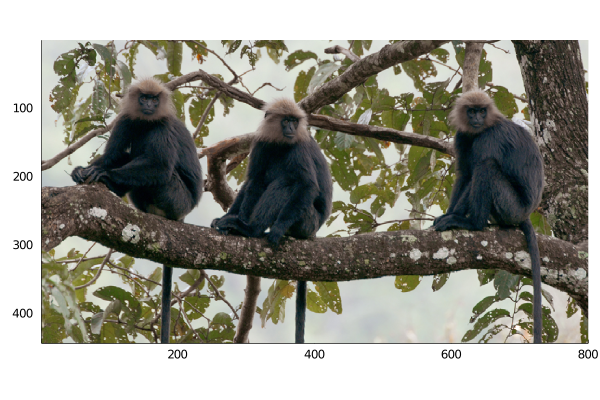

,Label,Latin Name,Common Name,Train Images,Validation Images
,String,String,String,Int64,Int64
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27


In [11]:
# read monkey_labels.txt
label_discription = read_label_discription(label_txt);

# show ranfom image
idx = rand(1:lastindex(train_raw_imgs_path));
show_image(train_raw_imgs_path[idx]; return_plot=false);
label_discription

## Pre-Processing

In [12]:
info_train_raw = get_imgs_size_info(train_raw_imgs_path);

In [13]:
# Show the number of images with width greater than height
println("Number of images with width greater than height: ", sum(first.(info_train_raw.size) .> last.(info_train_raw.size)))
println("Number of images with height greater than width: ", sum(first.(info_train_raw.size) .< last.(info_train_raw.size)))
first(info_train_raw, 5)

Number of images with width greater than height: 810
Number of images with height greater than width: 253


,path,size
,String,Tuple
1,猴子影像辨識 (10-monkey-species)/training/training/n0/n0018.jpg,"(550, 367)"
2,猴子影像辨識 (10-monkey-species)/training/training/n0/n0019.jpg,"(1920, 1080)"
3,猴子影像辨識 (10-monkey-species)/training/training/n0/n0020.jpg,"(337, 450)"
4,猴子影像辨識 (10-monkey-species)/training/training/n0/n0021.jpg,"(4367, 2911)"
5,猴子影像辨識 (10-monkey-species)/training/training/n0/n0022.jpg,"(1526, 1900)"


In [14]:
# Define the image size of the input neural network and save resized images
train_img_width = 150;
train_imgs_path, valid_imgs_path, train_img_size = resize_save_imgs(
    info_train_raw, train_raw_imgs_path, valid_raw_imgs_path;
    train_img_width=train_img_width, do_process=false
);

In [15]:
# read training images and labels
tmp_imgs = getarray.(train_imgs_path; img_size=nothing);

num_img = length(tmp_imgs);
train_imgs = Array{Float32, 4}(undef, train_img_size..., 3, num_img);
#for i in 1:num_img
#    train_imgs = Array{Float32, 4}(undef, train_img_size..., 3, num_img)
#    train_imgs[:, :, :, i] = convert(Array{Float32}, popfirst!(tmp_imgs));
#end
train_labels = reduce(hcat, splitpath.(dirname.(train_imgs_path)))[end, :];
train_labels = onehotbatch(train_labels, unique(train_labels))

# read validation images and labels
tmp_imgs = getarray.(valid_imgs_path; img_size=nothing);

num_img = length(tmp_imgs);
valid_imgs = Array{Float32, 4}(undef, train_img_size..., 3, num_img);
#for i in 1:num_img
#    valid_imgs = Array{Float32, 4}(undef, train_img_size..., 3, num_img)
#    valid_imgs[:, :, :, i] = convert(Array{Float32}, popfirst!(tmp_imgs));
#end
valid_labels = reduce(hcat, splitpath.(dirname.(valid_imgs_path)))[end, :];
valid_labels = onehotbatch(valid_labels, unique(valid_labels));

train_imgs = train_imgs |> gpu;
train_labels = train_labels |> gpu;
valid_imgs = valid_imgs |> gpu;
valid_labels = valid_labels |> gpu;

## NN Model

In [16]:
Flux.outdims(
    Chain(
        Conv((3, 3), 3=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 32=>64, pad=(1, 1), relu),
        Conv((3, 3), 64=>128, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 128=>128, pad=(1, 1), relu),
        Conv((3, 3), 128=>64, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 64=>32, pad=(1, 1), relu),
        Conv((3, 3), 32=>16, pad=(1, 1), relu),
        MaxPool((2, 2))),
    (123, 150)
)

Flux.outdims(
    Chain(
        Conv((3, 3), 3=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 32=>64, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 64=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),
        Conv((3, 3), 32=>16, pad=(1, 1), relu),
        MaxPool((2, 2))),
    (150, 123)
)

(9, 7)

In [17]:
## build NN model
function my_model(;complex=false)
    if complex
        return model = Chain(
            
            BatchNorm(3),
            Conv((3, 3), 3=>32, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            Conv((3, 3), 32=>64, pad=(1, 1), leakyrelu),
            
            BatchNorm(64),
            Conv((3, 3), 64=>128, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            Conv((3, 3), 128=>128, pad=(1, 1), leakyrelu),
            
            BatchNorm(128),
            Conv((3, 3), 128=>64, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            Conv((3, 3), 64=>32, pad=(1, 1), leakyrelu),
            
            BatchNorm(32),
            Conv((3, 3), 32=>16, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            Flux.flatten,
            Dense(1008, 128, leakyrelu),
            
            BatchNorm(128),
            Dense(128, 10),
            softmax
        )
    else
        return model = Chain(
            
            BatchNorm(3),
            Conv((3, 3), 3=>32, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            
            BatchNorm(32),
            Conv((3, 3), 32=>64, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            
            BatchNorm(64),
            Conv((3, 3), 64=>32, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            
            BatchNorm(32),
            Conv((3, 3), 32=>16, pad=(1, 1), leakyrelu),
            MaxPool((2, 2)),
            Flux.flatten,
            Dense(1008, 128, leakyrelu),
            
            BatchNorm(128),
            Dense(128, 10),
            softmax
        )
    end
end

my_model (generic function with 1 method)

In [18]:
## cross entropy

# loss(x, y) = Flux.crossentropy(model(x), y);

augment(x) = x .+ gpu(0.1f0 * randn(eltype(x), size(x)))
function loss(x, y)
    x̂ = augment(x)
    ŷ = model(x̂)
    return crossentropy(ŷ, y)
end

## kldivergence
function kldivergence(ŷ, y)
    y = clamp.(y, eps(Float32), Inf32);
    ŷ = clamp.(ŷ, eps(Float32), Inf32);
    entropy = sum(y .* log.(y)) * 1 //size(y,2)
    cross_entropy = crossentropy(ŷ, y)
    return entropy + cross_entropy
end

# Re-definition to fix interaction with CuArrays.
CuArrays.@cufunc kldivergence(ŷ, y) = begin
    y = clamp.(y, eps(Float32), Inf32);
    ŷ = clamp.(ŷ, eps(Float32), Inf32);
    entropy = sum(y .* log.(y)) * 1 //size(y,2)
    cross_entropy = crossentropy(ŷ, y)
    entropy + cross_entropy
end

# test
# > y_true = [[0 1]; [0 0]]
# > y_pred = [[0.6 0.4]; [0.4 0.6]]
# > kldivergence(y_pred, y_true)
# 0.548

# loss(x, y) = kldivergence(model(x), y);

# augment(x) = x .+ gpu(0.1f0 * randn(eltype(x), size(x)))
# function loss(x, y)
#     x̂ = augment(x)
#     ŷ = model(x̂)
#     return kldivergence(ŷ, y)
# end

In [19]:
# ## callback function
# # for Flux.train!

# struct StopException <: Exception end
# Base.showerror(io::IO, e::StopException) = print(io, "Early stop!")
# # try
# #     throw(StopException())
# # catch ex
# #     if ex isa StopException
# #         rethrow(ex)
# #     end
# # end

# valid_loss = typemax(Float32)
# num_early_stop, early_stop = 0, 4
# function evalcb()

#     valid_loss_tmp, acc = @show(eval_loss_accuracy())
#     if valid_loss_tmp > valid_loss
#         global num_early_stop += 1
#     else
#         global num_early_stop = 0
#     end
#     @printf("Number of early stop: %i\n", num_early_stop)
#     num_early_stop > early_stop && throw(StopException)
    
#     global valid_loss = valid_loss_tmp
# end

In [20]:
## evalution function
# accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

function eval_loss_accuracy(data_loader, model)
    testmode!(model)
    l = 0f0
    acc = 0
    ntot = 0
    for (x, y) in data_loader
        l += loss(x, y) * size(x)[end]
        acc += sum(onecold(model(x) |> cpu) .== onecold(y |> cpu))
        ntot += size(x)[end]
    end
    testmode!(model, false)
    return (loss = l/ntot,
            acc = acc/ntot)
end

eval_loss_accuracy (generic function with 1 method)

In [21]:
## hyper parameters
num_epochs = 150;
batchsize = 64;
learining_rate = 0.01;
decay = 0.8;
decay_step = 10;
clip = 1e-4;
l2_factor = 0.001;
early_stop = 50;

In [22]:
## DataLoader
train_loader = DataLoader(
    train_imgs, train_labels; batchsize=batchsize, shuffle=true
);
valid_loader = DataLoader(
    valid_imgs, valid_labels, batchsize=batchsize
);

## Training

In [23]:
for use_complex_model in [false, true]
    
    global model = my_model(complex=use_complex_model) |> gpu;
    global optimiser = Flux.Optimiser(ADAM(learining_rate, (0.9, 0.999)), WeightDecay(l2_factor))
    
    global best_acc = 0.0;
    global last_improvement = 0;
    global num_early_stop = 0;
    
    @info("Start training loop...")

    for epoch_idx in 1:num_epochs
        global best_acc, last_improvement
        p = ProgressMeter.Progress(length(train_loader); desc="Epoch [$epoch_idx]:")

        # Train for a single epoch
        for (x, y) in train_loader
            gs = Flux.gradient(params(model)) do
                loss(x, y)
            end
            Flux.Optimise.update!(optimiser, params(model), gs)
            ProgressMeter.next!(p)   # comment out for no progress bar
        end


        # Calculate accuracy:
        _loss, acc = eval_loss_accuracy(valid_loader, model)
        println("Epoch [$epoch_idx]:  Validation loss = $_loss,  Validation acc = $acc")

        # Early stop: If our accuracy is good enough, quit out.
        if acc >= 0.97
            @info(" -> Early-exiting: We reached our target accuracy of 97%")
            break
        end

        # If this is the best accuracy we've seen so far, save the model out
        if acc >= best_acc
            
            savepath = joinpath(".", "models");
            if use_complex_model
                model_filename = @sprintf("monkey_complex_acc[%03d%%].bson", acc*100)
            else
                model_filename = @sprintf("monkey_simple_acc[%03d%%].bson", acc*100)
            end
            
            !ispath(savepath) && mkpath(savepath)
            modelpath = joinpath(savepath, model_filename)
            println(@sprintf(" -> New best accuracy! Saving model out to %s", modelpath))
            let model = cpu(model)
                BSON.@save modelpath model epoch_idx acc
            end
            best_acc = acc
            last_improvement = epoch_idx
            num_early_stop = 0;
        else
            num_early_stop += 1;
        end

        if epoch_idx - last_improvement >= decay_step && optimiser.os[1].eta > clip
            optimiser.os[1].eta *= decay
            
            # After dropping learning rate, give it a few epochs to improve
            last_improvement = epoch_idx

            if optimiser.os[1].eta <= clip
               optimiser.os[1].eta = clip
            end
            @warn(" -> Haven't improved in a while, dropping learning rate to $(optimiser.os[1].eta)!")
        end

        # Early stop: no improvement
        if num_early_stop >= early_stop
            @warn(" -> No improvement, stop training.")
            break
        end
        
        if isnan(_loss)
            @warn(" -> The loss becomes NaN!")
            break
        end
    end
    
end

┌ Info: Start training loop...
└ @ Main In[23]:10
Epoch [1]:100%|█████████████████████████████████████████| Time: 0:04:14


Epoch [1]:  Validation loss = 3.2474225,  Validation acc = 0.10294117647058823
 -> New best accuracy! Saving model out to ./models/monkey_simple_acc[010%].bson


Epoch [2]:100%|█████████████████████████████████████████| Time: 0:03:28


Epoch [2]:  Validation loss = 2.747611,  Validation acc = 0.09926470588235294


Epoch [3]:100%|█████████████████████████████████████████| Time: 0:03:30


Epoch [3]:  Validation loss = 2.6249006,  Validation acc = 0.10294117647058823
 -> New best accuracy! Saving model out to ./models/monkey_simple_acc[010%].bson


Epoch [4]:100%|█████████████████████████████████████████| Time: 0:03:31


Epoch [4]:  Validation loss = 2.3477905,  Validation acc = 0.09558823529411764


Epoch [5]:100%|█████████████████████████████████████████| Time: 0:03:24


Epoch [5]:  Validation loss = 2.4016106,  Validation acc = 0.09558823529411764


Epoch [6]:100%|█████████████████████████████████████████| Time: 0:03:32


Epoch [6]:  Validation loss = 2.590514,  Validation acc = 0.11029411764705882
 -> New best accuracy! Saving model out to ./models/monkey_simple_acc[011%].bson


Epoch [7]:100%|█████████████████████████████████████████| Time: 0:03:28


Epoch [7]:  Validation loss = 2.8951473,  Validation acc = 0.09558823529411764


Epoch [8]:100%|█████████████████████████████████████████| Time: 0:03:24


Epoch [8]:  Validation loss = 2.3936493,  Validation acc = 0.09558823529411764


Epoch [9]:100%|█████████████████████████████████████████| Time: 0:03:31


Epoch [9]:  Validation loss = 2.3037972,  Validation acc = 0.10294117647058823


Epoch [10]:100%|████████████████████████████████████████| Time: 0:03:30


Epoch [10]:  Validation loss = 2.3620331,  Validation acc = 0.09558823529411764


Epoch [11]:100%|████████████████████████████████████████| Time: 0:03:29


Epoch [11]:  Validation loss = 2.3867264,  Validation acc = 0.10294117647058823


Epoch [12]:100%|████████████████████████████████████████| Time: 0:03:30


Epoch [12]:  Validation loss = 2.3314104,  Validation acc = 0.09558823529411764


Epoch [13]:100%|████████████████████████████████████████| Time: 0:03:25


Epoch [13]:  Validation loss = 2.342685,  Validation acc = 0.09558823529411764


Epoch [14]:100%|████████████████████████████████████████| Time: 0:03:27


Epoch [14]:  Validation loss = 2.3232012,  Validation acc = 0.10294117647058823


Epoch [15]:100%|████████████████████████████████████████| Time: 0:03:29


Epoch [15]:  Validation loss = 2.319459,  Validation acc = 0.09558823529411764


Epoch [16]:100%|████████████████████████████████████████| Time: 0:03:26


Epoch [16]:  Validation loss = 2.3213444,  Validation acc = 0.09558823529411764


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.008!
└ @ Main In[23]:68
Epoch [17]:100%|████████████████████████████████████████| Time: 0:03:30


Epoch [17]:  Validation loss = 2.3143308,  Validation acc = 0.10294117647058823


Epoch [18]:100%|████████████████████████████████████████| Time: 0:03:18


Epoch [18]:  Validation loss = 2.3316915,  Validation acc = 0.10294117647058823


Epoch [19]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [19]:  Validation loss = 2.3276186,  Validation acc = 0.10294117647058823


Epoch [20]:100%|████████████████████████████████████████| Time: 0:03:14


Epoch [20]:  Validation loss = 2.328076,  Validation acc = 0.10294117647058823


Epoch [21]:100%|████████████████████████████████████████| Time: 0:03:20


Epoch [21]:  Validation loss = 2.3038354,  Validation acc = 0.09558823529411764


Epoch [22]:100%|████████████████████████████████████████| Time: 0:03:13


Epoch [22]:  Validation loss = 2.3068461,  Validation acc = 0.10294117647058823


Epoch [23]:100%|████████████████████████████████████████| Time: 0:03:13


Epoch [23]:  Validation loss = 2.3110542,  Validation acc = 0.11029411764705882
 -> New best accuracy! Saving model out to ./models/monkey_simple_acc[011%].bson


Epoch [24]:100%|████████████████████████████████████████| Time: 0:36:14


Epoch [24]:  Validation loss = 2.3131356,  Validation acc = 0.10294117647058823


Epoch [25]:100%|████████████████████████████████████████| Time: 1:12:58


Epoch [25]:  Validation loss = 2.3097394,  Validation acc = 0.09558823529411764


Epoch [26]:100%|████████████████████████████████████████| Time: 1:16:32


Epoch [26]:  Validation loss = 2.3066044,  Validation acc = 0.09558823529411764


Epoch [27]:100%|████████████████████████████████████████| Time: 0:03:22


Epoch [27]:  Validation loss = 2.307342,  Validation acc = 0.09558823529411764


Epoch [28]:100%|████████████████████████████████████████| Time: 0:03:14


Epoch [28]:  Validation loss = 2.3021793,  Validation acc = 0.11029411764705882
 -> New best accuracy! Saving model out to ./models/monkey_simple_acc[011%].bson


Epoch [29]:100%|████████████████████████████████████████| Time: 0:03:14


Epoch [29]:  Validation loss = 2.300942,  Validation acc = 0.11029411764705882
 -> New best accuracy! Saving model out to ./models/monkey_simple_acc[011%].bson


Epoch [30]:100%|████████████████████████████████████████| Time: 0:03:13


Epoch [30]:  Validation loss = 2.3042908,  Validation acc = 0.09558823529411764


Epoch [31]:100%|████████████████████████████████████████| Time: 0:03:13


Epoch [31]:  Validation loss = 2.303832,  Validation acc = 0.09558823529411764


Epoch [32]:100%|████████████████████████████████████████| Time: 0:03:13


Epoch [32]:  Validation loss = 2.2979848,  Validation acc = 0.09558823529411764


Epoch [33]:100%|████████████████████████████████████████| Time: 0:03:13


Epoch [33]:  Validation loss = 2.3021832,  Validation acc = 0.09558823529411764


Epoch [34]:100%|████████████████████████████████████████| Time: 0:03:13


Epoch [34]:  Validation loss = 2.3017116,  Validation acc = 0.09558823529411764


Epoch [35]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [35]:  Validation loss = 2.3058758,  Validation acc = 0.10294117647058823


Epoch [36]:100%|████████████████████████████████████████| Time: 0:03:13


Epoch [36]:  Validation loss = 2.3041027,  Validation acc = 0.10294117647058823


Epoch [37]:100%|████████████████████████████████████████| Time: 0:03:14


Epoch [37]:  Validation loss = 2.3053129,  Validation acc = 0.10294117647058823


Epoch [38]:100%|████████████████████████████████████████| Time: 0:03:13


Epoch [38]:  Validation loss = 2.305908,  Validation acc = 0.09558823529411764


Epoch [39]:100%|████████████████████████████████████████| Time: 0:03:15


Epoch [39]:  Validation loss = 2.3019428,  Validation acc = 0.09558823529411764


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.0064!
└ @ Main In[23]:68
Epoch [40]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [40]:  Validation loss = 2.3017998,  Validation acc = 0.10294117647058823


Epoch [41]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [41]:  Validation loss = 2.305661,  Validation acc = 0.10294117647058823


Epoch [42]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [42]:  Validation loss = 2.3041742,  Validation acc = 0.09558823529411764


Epoch [43]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [43]:  Validation loss = 2.3029234,  Validation acc = 0.09926470588235294


Epoch [44]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [44]:  Validation loss = 2.301307,  Validation acc = 0.09558823529411764


Epoch [45]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [45]:  Validation loss = 2.3005857,  Validation acc = 0.10294117647058823


Epoch [46]:100%|████████████████████████████████████████| Time: 0:03:11


Epoch [46]:  Validation loss = 2.3031409,  Validation acc = 0.09558823529411764


Epoch [47]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [47]:  Validation loss = 2.3013103,  Validation acc = 0.09558823529411764


Epoch [48]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [48]:  Validation loss = 2.3031125,  Validation acc = 0.09558823529411764


Epoch [49]:100%|████████████████████████████████████████| Time: 0:03:11


Epoch [49]:  Validation loss = 2.3033457,  Validation acc = 0.09558823529411764


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.00512!
└ @ Main In[23]:68
Epoch [50]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [50]:  Validation loss = 2.302197,  Validation acc = 0.09558823529411764


Epoch [51]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [51]:  Validation loss = 2.304505,  Validation acc = 0.09926470588235294


Epoch [52]:100%|████████████████████████████████████████| Time: 0:03:13


Epoch [52]:  Validation loss = 2.302078,  Validation acc = 0.09926470588235294


Epoch [53]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [53]:  Validation loss = 2.3015249,  Validation acc = 0.09558823529411764


Epoch [54]:100%|████████████████████████████████████████| Time: 0:03:13


Epoch [54]:  Validation loss = 2.3018992,  Validation acc = 0.09558823529411764


Epoch [55]:100%|████████████████████████████████████████| Time: 0:03:10


Epoch [55]:  Validation loss = 2.3020234,  Validation acc = 0.09926470588235294


Epoch [56]:100%|████████████████████████████████████████| Time: 0:03:15


Epoch [56]:  Validation loss = 2.3020325,  Validation acc = 0.09926470588235294


Epoch [57]:100%|████████████████████████████████████████| Time: 0:03:10


Epoch [57]:  Validation loss = 2.3012447,  Validation acc = 0.09926470588235294


Epoch [58]:100%|████████████████████████████████████████| Time: 0:03:11


Epoch [58]:  Validation loss = 2.3012633,  Validation acc = 0.09926470588235294


Epoch [59]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [59]:  Validation loss = 2.3016107,  Validation acc = 0.09926470588235294


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.004096000000000001!
└ @ Main In[23]:68
Epoch [60]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [60]:  Validation loss = 2.3023522,  Validation acc = 0.09926470588235294


Epoch [61]:100%|████████████████████████████████████████| Time: 0:03:10


Epoch [61]:  Validation loss = 2.3010905,  Validation acc = 0.09558823529411764


Epoch [62]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [62]:  Validation loss = 2.3020904,  Validation acc = 0.09558823529411764


Epoch [63]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [63]:  Validation loss = 2.3014147,  Validation acc = 0.09558823529411764


Epoch [64]:100%|████████████████████████████████████████| Time: 0:03:11


Epoch [64]:  Validation loss = 2.3016074,  Validation acc = 0.09558823529411764


Epoch [65]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [65]:  Validation loss = 2.3038545,  Validation acc = 0.09558823529411764


Epoch [66]:100%|████████████████████████████████████████| Time: 0:03:10


Epoch [66]:  Validation loss = 2.3013592,  Validation acc = 0.09558823529411764


Epoch [67]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [67]:  Validation loss = 2.3013434,  Validation acc = 0.09558823529411764


Epoch [68]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [68]:  Validation loss = 2.3014016,  Validation acc = 0.09558823529411764


Epoch [69]:100%|████████████████████████████████████████| Time: 0:03:11


Epoch [69]:  Validation loss = 2.300929,  Validation acc = 0.09926470588235294


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.0032768000000000007!
└ @ Main In[23]:68
Epoch [70]:100%|████████████████████████████████████████| Time: 0:03:11


Epoch [70]:  Validation loss = 2.3017144,  Validation acc = 0.10294117647058823


Epoch [71]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [71]:  Validation loss = 2.3022869,  Validation acc = 0.09558823529411764


Epoch [72]:100%|████████████████████████████████████████| Time: 0:03:12


Epoch [72]:  Validation loss = 2.3005047,  Validation acc = 0.09558823529411764


Epoch [73]:100%|████████████████████████████████████████| Time: 0:03:10


Epoch [73]:  Validation loss = 2.3010452,  Validation acc = 0.09558823529411764


Epoch [74]:100%|████████████████████████████████████████| Time: 0:03:11


Epoch [74]:  Validation loss = 2.3021152,  Validation acc = 0.09558823529411764


Epoch [75]:100%|████████████████████████████████████████| Time: 0:03:10


Epoch [75]:  Validation loss = 2.30167,  Validation acc = 0.09558823529411764


Epoch [76]:100%|████████████████████████████████████████| Time: 0:03:11


Epoch [76]:  Validation loss = 2.302133,  Validation acc = 0.10294117647058823


Epoch [77]:100%|████████████████████████████████████████| Time: 0:03:11


Epoch [77]:  Validation loss = 2.3015745,  Validation acc = 0.10294117647058823


Epoch [78]:100%|████████████████████████████████████████| Time: 0:03:11


Epoch [78]:  Validation loss = 2.302212,  Validation acc = 0.10294117647058823


Epoch [79]:100%|████████████████████████████████████████| Time: 0:03:10


Epoch [79]:  Validation loss = 2.3019388,  Validation acc = 0.10294117647058823


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.002621440000000001!
└ @ Main In[23]:68
┌ Warning:  -> No improvement, stop training.
└ @ Main In[23]:73
┌ Info: Start training loop...
└ @ Main In[23]:10
Epoch [1]:100%|█████████████████████████████████████████| Time: 0:06:30


Epoch [1]:  Validation loss = Inf,  Validation acc = 0.09926470588235294
 -> New best accuracy! Saving model out to ./models/monkey_complex_acc[010%].bson


Epoch [2]:100%|█████████████████████████████████████████| Time: 0:06:22


Epoch [2]:  Validation loss = Inf,  Validation acc = 0.10294117647058823
 -> New best accuracy! Saving model out to ./models/monkey_complex_acc[010%].bson


Epoch [3]:100%|█████████████████████████████████████████| Time: 0:06:23


Epoch [3]:  Validation loss = 16.267618,  Validation acc = 0.10294117647058823
 -> New best accuracy! Saving model out to ./models/monkey_complex_acc[010%].bson


Epoch [4]:100%|█████████████████████████████████████████| Time: 0:06:25


Epoch [4]:  Validation loss = 3.35653,  Validation acc = 0.10294117647058823
 -> New best accuracy! Saving model out to ./models/monkey_complex_acc[010%].bson


Epoch [5]:100%|█████████████████████████████████████████| Time: 0:06:23


Epoch [5]:  Validation loss = 3.1366265,  Validation acc = 0.09558823529411764


Epoch [6]:100%|█████████████████████████████████████████| Time: 0:06:22


Epoch [6]:  Validation loss = 3.6963742,  Validation acc = 0.10294117647058823
 -> New best accuracy! Saving model out to ./models/monkey_complex_acc[010%].bson


Epoch [7]:100%|█████████████████████████████████████████| Time: 0:06:26


Epoch [7]:  Validation loss = 3.7192588,  Validation acc = 0.09558823529411764


Epoch [8]:100%|█████████████████████████████████████████| Time: 0:06:21


Epoch [8]:  Validation loss = 3.146726,  Validation acc = 0.10294117647058823
 -> New best accuracy! Saving model out to ./models/monkey_complex_acc[010%].bson


Epoch [9]:100%|█████████████████████████████████████████| Time: 0:06:20


Epoch [9]:  Validation loss = 2.4531062,  Validation acc = 0.10294117647058823
 -> New best accuracy! Saving model out to ./models/monkey_complex_acc[010%].bson


Epoch [10]:100%|████████████████████████████████████████| Time: 0:06:31


Epoch [10]:  Validation loss = 2.7809737,  Validation acc = 0.10294117647058823
 -> New best accuracy! Saving model out to ./models/monkey_complex_acc[010%].bson


Epoch [11]:100%|████████████████████████████████████████| Time: 0:06:23


Epoch [11]:  Validation loss = 2.3671741,  Validation acc = 0.09926470588235294


Epoch [12]:100%|████████████████████████████████████████| Time: 0:06:23


Epoch [12]:  Validation loss = 2.4530048,  Validation acc = 0.09558823529411764


Epoch [13]:100%|████████████████████████████████████████| Time: 0:06:25


Epoch [13]:  Validation loss = 2.427059,  Validation acc = 0.11029411764705882
 -> New best accuracy! Saving model out to ./models/monkey_complex_acc[011%].bson


Epoch [14]:100%|████████████████████████████████████████| Time: 0:06:20


Epoch [14]:  Validation loss = 2.3491452,  Validation acc = 0.10294117647058823


Epoch [15]:100%|████████████████████████████████████████| Time: 0:06:26


Epoch [15]:  Validation loss = 2.337772,  Validation acc = 0.11029411764705882
 -> New best accuracy! Saving model out to ./models/monkey_complex_acc[011%].bson


Epoch [16]:100%|████████████████████████████████████████| Time: 0:06:28


Epoch [16]:  Validation loss = 2.3265028,  Validation acc = 0.10294117647058823


Epoch [17]:100%|████████████████████████████████████████| Time: 0:06:24


Epoch [17]:  Validation loss = 2.3386588,  Validation acc = 0.09926470588235294


Epoch [18]:100%|████████████████████████████████████████| Time: 0:06:25


Epoch [18]:  Validation loss = 2.4210424,  Validation acc = 0.10294117647058823


Epoch [19]:100%|████████████████████████████████████████| Time: 0:06:31


Epoch [19]:  Validation loss = 2.3309517,  Validation acc = 0.11029411764705882
 -> New best accuracy! Saving model out to ./models/monkey_complex_acc[011%].bson


Epoch [20]:100%|████████████████████████████████████████| Time: 0:06:30


Epoch [20]:  Validation loss = 2.3946955,  Validation acc = 0.09926470588235294


Epoch [21]:100%|████████████████████████████████████████| Time: 0:06:24


Epoch [21]:  Validation loss = 2.3770585,  Validation acc = 0.09558823529411764


Epoch [22]:100%|████████████████████████████████████████| Time: 0:06:27


Epoch [22]:  Validation loss = 2.3782902,  Validation acc = 0.10294117647058823


Epoch [23]:100%|████████████████████████████████████████| Time: 0:06:26


Epoch [23]:  Validation loss = 2.3153324,  Validation acc = 0.09558823529411764


Epoch [24]:100%|████████████████████████████████████████| Time: 0:06:25


Epoch [24]:  Validation loss = 2.3073304,  Validation acc = 0.09558823529411764


Epoch [25]:100%|████████████████████████████████████████| Time: 0:06:43


Epoch [25]:  Validation loss = 2.4080067,  Validation acc = 0.09926470588235294


Epoch [26]:100%|████████████████████████████████████████| Time: 0:06:26


Epoch [26]:  Validation loss = 2.3863482,  Validation acc = 0.10294117647058823


Epoch [27]:100%|████████████████████████████████████████| Time: 0:06:23


Epoch [27]:  Validation loss = 2.3182414,  Validation acc = 0.09926470588235294


Epoch [28]:100%|████████████████████████████████████████| Time: 0:06:28


Epoch [28]:  Validation loss = 2.3070812,  Validation acc = 0.09926470588235294


Epoch [29]:100%|████████████████████████████████████████| Time: 0:06:24


Epoch [29]:  Validation loss = 2.3403661,  Validation acc = 0.09558823529411764


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.008!
└ @ Main In[23]:68
Epoch [30]:100%|████████████████████████████████████████| Time: 0:06:28


Epoch [30]:  Validation loss = 2.321228,  Validation acc = 0.09558823529411764


Epoch [31]:100%|████████████████████████████████████████| Time: 0:06:25


Epoch [31]:  Validation loss = 2.314594,  Validation acc = 0.09926470588235294


Epoch [32]:100%|████████████████████████████████████████| Time: 0:06:24


Epoch [32]:  Validation loss = 2.3083937,  Validation acc = 0.09926470588235294


Epoch [33]:100%|████████████████████████████████████████| Time: 0:06:26


Epoch [33]:  Validation loss = 2.3083954,  Validation acc = 0.09558823529411764


Epoch [34]:100%|████████████████████████████████████████| Time: 0:06:24


Epoch [34]:  Validation loss = 2.309306,  Validation acc = 0.09558823529411764


Epoch [35]:100%|████████████████████████████████████████| Time: 0:06:28


Epoch [35]:  Validation loss = 2.3066998,  Validation acc = 0.09926470588235294


Epoch [36]:100%|████████████████████████████████████████| Time: 0:06:29


Epoch [36]:  Validation loss = 2.3385837,  Validation acc = 0.09926470588235294


Epoch [37]:100%|████████████████████████████████████████| Time: 0:06:24


Epoch [37]:  Validation loss = 2.30159,  Validation acc = 0.09926470588235294


Epoch [38]:100%|████████████████████████████████████████| Time: 0:06:36


Epoch [38]:  Validation loss = 2.3086376,  Validation acc = 0.09926470588235294


Epoch [39]:100%|████████████████████████████████████████| Time: 0:06:27


Epoch [39]:  Validation loss = 2.3067062,  Validation acc = 0.09926470588235294


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.0064!
└ @ Main In[23]:68
Epoch [40]:100%|████████████████████████████████████████| Time: 0:06:22


Epoch [40]:  Validation loss = 2.30929,  Validation acc = 0.09926470588235294


Epoch [41]:100%|████████████████████████████████████████| Time: 0:06:27


Epoch [41]:  Validation loss = 2.3089714,  Validation acc = 0.09926470588235294


Epoch [42]:100%|████████████████████████████████████████| Time: 0:06:28


Epoch [42]:  Validation loss = 2.3069286,  Validation acc = 0.09926470588235294


Epoch [43]:100%|████████████████████████████████████████| Time: 0:06:29


Epoch [43]:  Validation loss = 2.3180537,  Validation acc = 0.09926470588235294


Epoch [44]:100%|████████████████████████████████████████| Time: 0:06:27


Epoch [44]:  Validation loss = 2.3145766,  Validation acc = 0.09926470588235294


Epoch [45]:100%|████████████████████████████████████████| Time: 0:06:26


Epoch [45]:  Validation loss = 2.306266,  Validation acc = 0.09926470588235294


Epoch [46]:100%|████████████████████████████████████████| Time: 0:06:34


Epoch [46]:  Validation loss = 2.3025174,  Validation acc = 0.09926470588235294


Epoch [47]:100%|████████████████████████████████████████| Time: 0:06:29


Epoch [47]:  Validation loss = 2.3017323,  Validation acc = 0.09926470588235294


Epoch [48]:100%|████████████████████████████████████████| Time: 0:06:29


Epoch [48]:  Validation loss = 2.304423,  Validation acc = 0.09926470588235294


Epoch [49]:100%|████████████████████████████████████████| Time: 0:06:24


Epoch [49]:  Validation loss = 2.3068116,  Validation acc = 0.09926470588235294


┌ Warning:  -> Haven't improved in a while, dropping learning rate to 0.00512!
└ @ Main In[23]:68
Epoch [50]:100%|████████████████████████████████████████| Time: 0:06:35


Epoch [50]:  Validation loss = 2.3039455,  Validation acc = 0.09558823529411764


Epoch [51]:100%|████████████████████████████████████████| Time: 0:06:24


Epoch [51]:  Validation loss = 2.3054333,  Validation acc = 0.09558823529411764


Epoch [52]:100%|████████████████████████████████████████| Time: 0:06:48


Epoch [52]:  Validation loss = 2.303223,  Validation acc = 0.09926470588235294


Epoch [53]:100%|████████████████████████████████████████| Time: 0:06:29


Epoch [53]:  Validation loss = 2.3022146,  Validation acc = 0.09926470588235294


Epoch [54]:100%|████████████████████████████████████████| Time: 0:06:32


Epoch [54]:  Validation loss = 2.3032413,  Validation acc = 0.09926470588235294


Epoch [55]:100%|████████████████████████████████████████| Time: 0:06:32


Epoch [55]:  Validation loss = 2.3035226,  Validation acc = 0.09926470588235294


Epoch [56]:100%|████████████████████████████████████████| Time: 0:06:32


Epoch [56]:  Validation loss = 2.3017645,  Validation acc = 0.09926470588235294


Epoch [57]:100%|████████████████████████████████████████| Time: 0:06:39


Epoch [57]:  Validation loss = 2.3019853,  Validation acc = 0.09926470588235294


Epoch [58]:100%|████████████████████████████████████████| Time: 0:30:11


Epoch [58]:  Validation loss = 2.301214,  Validation acc = 0.09926470588235294


Epoch [59]: 28%|███████████▏                            |  ETA: 0:05:59

LoadError: InterruptException:

## Model Evaluation

In [24]:
## load best model
all_modelpath = recursive_readdir("models\\")
best_acc, best_acc_idx = findmax(map(x->parse(Int, x.match), match.(r"[[:<:]]\d+[[:>:]]", all_modelpath)))
best_modelpath = all_modelpath[best_acc_idx]
println("Best accuracy: $best_acc")
BSON.@load best_modelpath model

LoadError: SystemError: unable to read directory models\: No such file or directory

In [ ]:
## model evalution
model = model |> gpu;
testmode!(model);
best_loss, best_acc = eval_loss_accuracy(train_loader, model);
println("Training Loss: $best_loss, Accuracy: $best_acc");
best_loss, best_acc = eval_loss_accuracy(valid_loader, model);
println("Validation Loss: $best_loss, Accuracy: $best_acc");
testmode!(model, false);

In [ ]:
reduce(vcat, [onecold(model(x) |> cpu) for (x, y) in valid_loader])

In [ ]:
onecold(valid_labels |> cpu)

In [ ]:
unique(reduce(hcat, splitpath.(dirname.(valid_imgs_path)))[end, :])